# data2a - Side of the car

In [ ]:
import urllib.request
import pickle
import matplotlib.pyplot as plt
from IPython.display import display,Image,clear_output
import numpy as np
import os
import h5py
import json

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report,confusion_matrix
from collections import Counter,defaultdict

In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Flatten, Dropout, Activation, add
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.applications.vgg16 import VGG16,preprocess_input
#from keras.utils.np_utils import to_categorical
from keras.utils import get_file
from keras import optimizers
from keras.regularizers import l1, l2
from keras.callbacks import ModelCheckpoint, History

In [ ]:
from keras import backend as K
K.backend()

'tensorflow'

In [ ]:
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
weights_path = get_file('vgg16_weights.h5', WEIGHTS_PATH_NO_TOP)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Defining input data

In [ ]:
# path to the model weights file
location = '/content/drive/My Drive/TVS/car-damage-dataset/data2a'
top_model_weights_path=location+'/top_model_weights.h5' # will be saved into when we create our model
fine_tuned_model_path = location+'/ft_model.h5'

# dimensions of our images
img_width, img_height = 256, 256

train_data_dir = location+'/training'
val_data_dir = location+'/validation'

train_samples = [len(os.listdir(os.path.join(train_data_dir,i))) for i in os.listdir(train_data_dir)]
nb_train_samples = sum(train_samples)
val_samples = [len(os.listdir(os.path.join(val_data_dir,i))) for i in os.listdir(val_data_dir)]
nb_val_samples = sum(val_samples)

nb_epoch = 50

In [ ]:
train_samples

[272, 425, 288]

In [ ]:
K.image_data_format()

'channels_last'

In [ ]:
if K.image_data_format() == 'channels_first':
    input_shape = (3,img_height,img_widthdth)
else:
    input_shape = (img_height,img_width,3)

In [ ]:
input_shape

(256, 256, 3)

In [ ]:
# def load_vgg16(weights_path='../vgg16_weights.h5'):
#     model = Sequential()
#     model.add(ZeroPadding2D(padding=(1,1),input_shape=(224,224,3)))   # for best performance you should set
#                                                                       # `image_data_format='channels_last'`
#                                                                       # in your Keras config
#                                                                       # at ~/.keras/keras.json.
#     model.add(Convolution2D(filters=64, kernel_size=3, strides=3, activation='relu'))
#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=64, kernel_size=3, strides=3, activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=128, kernel_size=3, strides=3, activation='relu'))
#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=128, kernel_size=3, strides=3, activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=256, kernel_size=3, strides=3, activation='relu'))

#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=256, kernel_size=3, strides=3, activation='relu'))
#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=256, kernel_size=3, strides=3, activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=512, kernel_size=3, strides=3, activation='relu'))
#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=512, kernel_size=3, strides=3, activation='relu'))
#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=512, kernel_size=3, strides=3, activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=512, kernel_size=3, strides=3, activation='relu'))
#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=512, kernel_size=3, strides=3, activation='relu'))
#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=512, kernel_size=3, strides=3, activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     # assert os.path.exists(weights_path), 'Model weights not found (see "weights_path")'

#     # Use below code to freeze the conv model i.e. its learning
#     '''
#     for layer in model.layers:
#         layer.trainable = False
#     '''

#     if weights_path:
#     # note: this chops off the last layers of VGG16

#     # loads the weights of the VGG16 networks
#     # NOTE: when there is a complete match between model definition
#     # and your weights savefile, you can simply call model.load_weights(filename)
#         f = h5py.File(weights_path)
#         # LEFT CURRENTLY

In [ ]:
base_model = VGG16(weights='imagenet',include_top=False,input_shape=input_shape ,pooling=max)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
# Set base_model layers to non-trainable
for layer in base_model.layers:
    layer.trainable=False

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
def preprocess_input_vgg(x):
    """Wrapper around keras.applications.vgg16.preprocess_input()
    to make it compatible for use with keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument.

    Parameters
    ----------
    x : a numpy 3darray (a single image to be preprocessed)

    Note we cannot pass keras.applications.vgg16.preprocess_input()
    directly to to keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument because the former expects a
    4D tensor whereas the latter expects a 3D tensor. Hence the
    existence of this wrapper.

    Returns a numpy 3darray (the preprocessed image).

    """
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]

In [ ]:
def save_bottleneck_features(location):    # SAMAJANA
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)

    if(os.path.exists(location+'/bottleneck_features_train.npy')):
        print('Already exists',location+'/bottleneck_features_train.npy')
    else:
        train_generator = datagen.flow_from_directory(train_data_dir,
                                                      target_size=(img_height,img_width),
                                                      batch_size=16,
                                                      class_mode=None,         # only data, no labels
                                                      shuffle=False)           # keep data in same order as labels

        bottleneck_features_train = base_model.predict_generator(train_generator,
                                                                 nb_train_samples / 16,
                                                                 verbose=1)

        print('Saving',location+'/bottleneck_features_train.npy')
        np.save(open(location+'/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)
        #np.save(location+'/bottleneck_features_train.npy',bottleneck_features_train)

    if(os.path.exists(location+'/bottleneck_features_val.npy')):
        print('Already exists',location+'/bottleneck_features_val.npy')
    else:
        # Repeat it with validation data
        val_generator = datagen.flow_from_directory(val_data_dir,
                                                    target_size=(img_height,img_width),
                                                    batch_size=16,
                                                    class_mode=None,
                                                    shuffle=False)

        bottleneck_features_val = base_model.predict_generator(val_generator,
                                                               nb_val_samples / 16,
                                                               verbose=1)
        print('Saving',location+'/bottleneck_features_val.npy')
        np.save(open(location+'/bottleneck_features_val.npy','wb'),bottleneck_features_val)
        #np.save(location+'/bottleneck_features_val.npy',bottleneck_features_train)

In [ ]:
# load saved data and train a small, fully-connected ModelCheckpoint
def train_categorical_model(location):
    # the features were saved in order, so recreating the labels is not hard
    train_data = np.load(open(location+'/bottleneck_features_train.npy', 'rb'))
    print(train_data.shape[1:])
    train_labels = np.array([0]*train_samples[0]
                            +[1]*train_samples[1]
                            +[2]*train_samples[2])

    train_labels = to_categorical(train_labels)

    val_data = np.load(open(location+'/bottleneck_features_val.npy','rb'))
    val_labels = np.array([0]*val_samples[0]
                          +[1]*val_samples[1]
                          +[2]*val_samples[2])

    val_labels = to_categorical(val_labels)

    model = Sequential()
    model.add(Flatten(input_shape=(train_data.shape[1:])))     # 8, 8, 512
    model.add(Dense(units=256,activation='relu',kernel_regularizer=l2(l=0.01)))
    #model.add(Dense(units=256,activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=3,activation='softmax'))             # upped to 3 so activation softmax

    model.compile(optimizer=optimizers.SGD(lr=0.0001,momentum=0.9),
                  loss='categorical_crossentropy',
                 metrics = ['accuracy'])

    checkpoint = ModelCheckpoint(top_model_weights_path,
                                 monitor='val_acc',
                                 verbose=1,
                                 save_best_only=True,
                                 save_weights_only=True,
                                 mode='auto')     # ?read documentation

    fit = model.fit(train_data,train_labels,
                    epochs=nb_epoch,
                    batch_size=16,
                    validation_data=(val_data,val_labels),
                    callbacks=[checkpoint])

    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(units=256,activation='relu',kernel_regularizer=l2(l=0.01)))
top_model.add(Dropout(rate=0.5))
top_model.add(Dense(units=3,activation='sigmoid'))

top_model.load_weights(top_model_weights_path) # load weights_path

#base_model.add(top_model)

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
#print(model.layers[-1].get_weights())
#print(top_model.get_weights())
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
def finetune_categorical_model(location):
    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(units=256,activation='relu',kernel_regularizer=l2(l=0.01)))
    top_model.add(Dropout(rate=0.5))
    top_model.add(Dense(units=3,activation='softmax'))

    top_model.load_weights(top_model_weights_path) # load weights_path

    #base_model.add(top_model)

    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    #model.add(top_model)

#     # set the first 25 layers (up to the last conv block)
#     # to non-trainable - weights will not be updated
#     for layer in model.layers[:25]:
#         layer.trainable=False

    # compile the model with a SGD/momentum optimizer
    # and a very slow learning rate
    model.compile(optimizer=optimizers.SGD(lr=0.00001,momentum=0.9),    # reduced learning rate by 1/10
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)

    train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=8,
                                                        class_mode='categorical')

    test_generator = test_datagen.flow_from_directory(val_data_dir,
                                                      target_size=(img_height, img_width),
                                                      batch_size=8,
                                                      class_mode='categorical',
                                                      shuffle=False)
    checkpoint = ModelCheckpoint(filepath=fine_tuned_model_path,
                                 monitor='val_acc',
                                 verbose=1,
                                 save_best_only=True,
                                 save_weights_only=False,
                                 mode='auto')

    # fine-tune the model
    fit = model.fit_generator(train_generator,
                                   steps_per_epoch=nb_train_samples/8,
                                   #epochs=nb_epoch,
                                   epochs=10,
                                   validation_data=test_generator,
                                   validation_steps=nb_val_samples/8,
                                   verbose=1,
                                   callbacks=[checkpoint])

    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
def evaluate_categorical_model(model,directory,labels,Force=False):
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)

    if(os.path.exists(location+'/pred_labels.npy')) and not Force:
        print('Already exists',location+'/pred_labels.npy')
        pred_labels = np.load(open(location+'/pred_labels.npy', 'rb'))
    else:
        # Repeat it with validation data
        test_generator = test_datagen.flow_from_directory(directory=y,
                                                     target_size=(img_height,img_width),
                                                     batch_size=8,
                                                     class_mode='categorical',     # categorical for multiclass
                                                     shuffle=False)

        predictions = model.predict_generator(test_generator,
                                              steps=len(labels)/8,
                                              verbose=1)

        # use for multiclass
        pred_labels = np.argmax(predictions, axis=1)

        # pred_labels = [0 if i <0.5 else 1 for i in predictions]
        print('Saving',location+'/pred_labels.npy')
        np.save(open(location+'/pred_labels.npy','wb'),pred_labels)
        #np.save(location+'/bottleneck_features_val.npy',bottleneck_features_train)

    print()
    print(classification_report(labels, pred_labels))
    print()
    cm = confusion_matrix(labels, pred_labels)
#     sns.heatmap(cm, annot=True, fmt='g');
    return cm

In [ ]:
def plot_metrics(hist, stop=50):  # stop -> no of data pts in plot
                                # hist(history) -> dict
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    # axes = axes.flatten()   # flatten -> numpy flatten

    ax0.plot(range(stop), hist['acc'], label='Training', color='#FF533D')
    ax0.plot(range(stop), hist['val_acc'], label='Validation', color='#03507E')
    ax0.set_title('Accuracy')
    ax0.set_ylabel('Accuracy')
    ax0.set_xlabel('Epoch')
    ax0.legend(loc='lower right')

    ax1.plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    ax1.plot(range(stop), hist['val_loss'],label='Validation', color='#03507E')
    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='upper right')

    plt.tight_layout()

    print("Best Model: ")
    print_best_model_results(hist)

In [ ]:
def view_images(img_dir,img_list):
    for img in img_list:
        clear_output()
        display(Image(img_dir+img))
        num = input("c to continue, q to quit")
        if num == 'c':
            pass
        else:
            return 'Finished for now.'

In [ ]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_acc'])
    print('epoch:', best_epoch+1,', val_acc:', model_hist['val_acc'][best_epoch],', val_loss:',
          model_hist['val_loss'][best_epoch])

### Training

In [ ]:
# do not rerun!!
save_bottleneck_features(location)

Already exists /content/drive/My Drive/TVS/car-damage-dataset/data2a/bottleneck_features_train.npy
Already exists /content/drive/My Drive/TVS/car-damage-dataset/data2a/bottleneck_features_val.npy


In [ ]:
sns.set_style('whitegrid')

In [ ]:
d2a_model1,d2a_history1 = train_categorical_model(location)

(8, 8, 512)


ValueError: ignored

In [ ]:
# Winner
plot_metrics(d2a_history1)  # sgd with lr = 0.0001, sigmoid, with l2 = 0.001

NameError: ignored

In [ ]:
d2a_model2,d2a_history2 = train_categorical_model(location)    # sgd with lr = 0.0001, with NO regularization

(8, 8, 512)


ValueError: ignored

Best Model: 
epoch: 29 , val_acc: 0.748538011347 , val_loss: 3.23482431306


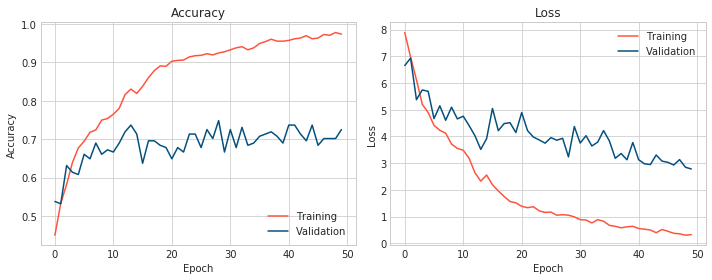

In [ ]:
plot_metrics(d2a_history2)

### Fine Tuning

In [ ]:
ft_model,ft_history = finetune_categorical_model(location)   #run

Found 979 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
Epoch 1/10
123/122 [==============================] - 1304s 11s/step - loss: 9.4369 - acc: 0.6670 - val_loss: 8.5438 - val_acc: 0.7485
Epoch 2/10
123/122 [==============================] - 1282s 10s/step - loss: 9.5613 - acc: 0.6568 - val_loss: 8.3813 - val_acc: 0.7310
Epoch 3/10
123/122 [==============================] - 1281s 10s/step - loss: 9.0993 - acc: 0.6731 - val_loss: 8.2213 - val_acc: 0.7368
Epoch 4/10
123/122 [==============================] - 1283s 10s/step - loss: 9.1564 - acc: 0.6507 - val_loss: 8.0548 - val_acc: 0.7602
Epoch 5/10
123/122 [==============================] - 1284s 10s/step - loss: 8.8281 - acc: 0.6674 - val_loss: 7.9207 - val_acc: 0.7661
Epoch 6/10
123/122 [==============================] - 1281s 10s/step - loss: 8.1841 - acc: 0.6931 - val_loss: 7.7342 - val_acc: 0.7661
Epoch 7/10
123/122 [==============================] - 1282s 10s/step - loss: 7.9604 - acc: 0.6656 - val_loss

Best Model: 
epoch: 5 , val_acc: 0.766081871694 , val_loss: 7.92072858308


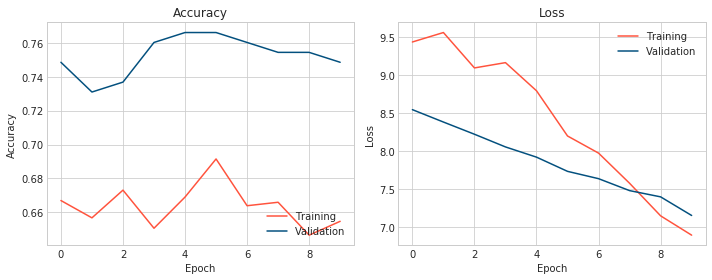

In [ ]:
# Winner
plot_metrics(ft_history,stop=10)   # sgd with lr = 0.0001, sigmoid, with l2 = 0.001

In [ ]:
ft_model = load_model(fine_tuned_model_path)

In [ ]:
with open(location+'/top_history.txt') as f:
    top_history = json.load(f)

Best Model: 
epoch: 28 , val_acc: 0.7368421070059837 , val_loss: 8.616565804732474


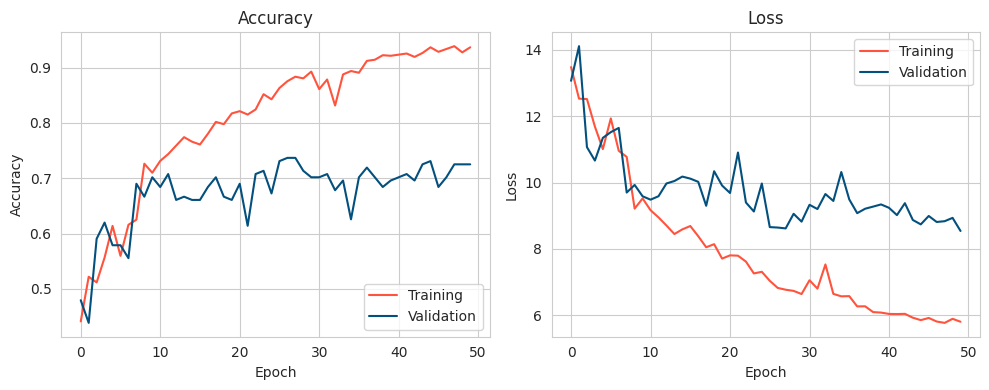

In [ ]:
plot_metrics(top_history)

In [ ]:
with open(location+'/ft_history.txt') as f:
    ft_history = json.load(f)

In [ ]:
val_labels = np.array([0] * val_samples[0] +
                      [1] * val_samples[1] +
                      [2] * val_samples[2])
val_labels = to_categorical(val_labels)
val_labels
np.argmax(val_labels,axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2])

In [ ]:
pred_labels = np.load(open(location+'/pred_labels.npy', 'rb'))
pred_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0,
       2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 2, 0, 0, 2, 2, 2, 2, 1, 0,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 0, 2, 0, 2, 1, 2, 0, 2, 0, 1, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2])

In [ ]:
cm = evaluate_categorical_model(ft_model, val_data_dir, np.argmax(val_labels,axis=1),Force=True)

NameError: ignored

In [ ]:
def plot_acc_metrics(hist1, hist2, stop1=50,stop2=10):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,6))

    axes = axes.flatten()

    axes[0].plot(range(stop1), hist1['acc'], label='Training', color='#FF533D')
    axes[0].plot(range(stop1), hist1['val_acc'], label='Validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')

    axes[1].plot(range(stop2), hist2['acc'], label='Training', color='#FF533D')
    axes[1].plot(range(stop2), hist2['val_acc'], label='Validation', color='#03507E')
    axes[1].set_title('Fine-tuning')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')

    plt.tight_layout()

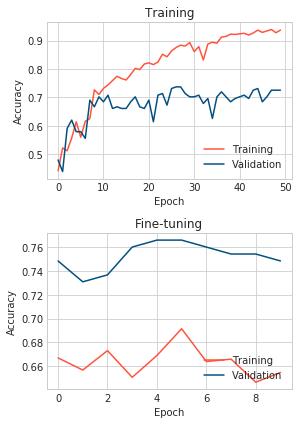

In [ ]:
plot_acc_metrics(top_history, ft_history)

In [ ]:
heatmap_labels = ['Front', 'Rear', 'Side']

In [ ]:
sns.heatmap(cm, annot=True, annot_kws={"size": 14},
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

NameError: ignored

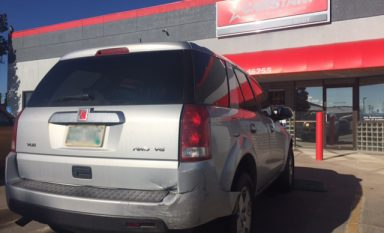

In [ ]:
Image('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg')

In [ ]:
def location_assessment(img_url,model):
    print("Determining location of damage...")
    urllib.request.urlretrieve(img_url,'save_third_gate.png')
    img = img_to_array(load_img('save_third_gate.png',target_size=(256,256)))
    img = img.reshape((1,)+img.shape)
    pred = model.predict(img)
    pred_label = np.argmax(pred,axis=1)
    d = {0:'Front',1:'Rear',2:'Side'}
    for key in d.keys():
        if key == pred_label[0]:
            print("Assessment: {} damage to vehicle".format(d[key]))
    print("Location assessment complete.")

In [ ]:
location_assessment('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg',ft_model)

Determining location of damage...
1/1 [==============================] - 8s 8s/step
Assessment: Rear damage to vehicle
Location assessment complete.


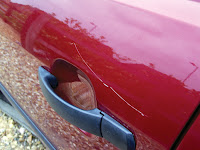

In [ ]:
Image('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg')

Determining location of damage...
1/1 [==============================] - 0s 21ms/step
Assessment: Side damage to vehicle
Location assessment complete.


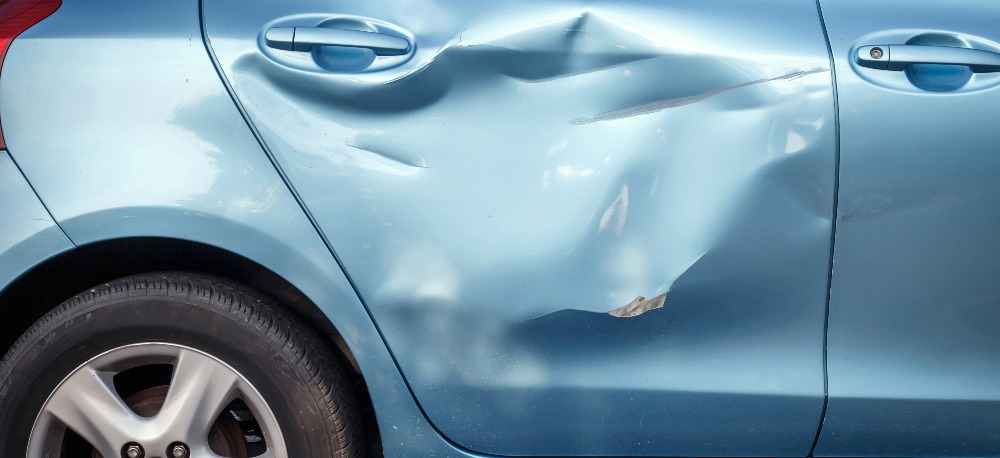

In [ ]:
Image('https://www.gerbercollision.com/includes/uploads/Articles/Resize_Car-Frame%20Damage-101.jpg')

In [ ]:
location_assessment('https://www.gerbercollision.com/includes/uploads/Articles/Resize_Car-Frame%20Damage-101.jpg',ft_model)

Determining location of damage...
1/1 [==============================] - 0s 33ms/step
Assessment: Side damage to vehicle
Location assessment complete.


In [ ]:
def get_edge_cases(model, directory, exp_result, false_result):
    img_list = os.listdir(directory)
    edge_list = []
    for name in img_list:
        img = load_img(directory+name, target_size=(256, 256)) # this is a PIL image
        x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
        x = x.reshape((1,) + x.shape) # this is a Numpy array with shape (1, 3, 256, 256)
        pred = model.predict(x)
        pred_label = np.argmax(pred, axis=1)
        if pred_label[0] == false_result:
            edge_list.append(name)
    return edge_list

In [ ]:
front1 = get_edge_cases(ft_model, './car-damage-dataset/data2a/validation/00-front/', 0, 1) # true front, predicted rear - 8
front2 = get_edge_cases(ft_model, './car-damage-dataset/data2a/validation/00-front/', 0, 2) # true front, predicted side - 7

In [ ]:
rear1 = get_edge_cases(ft_model, './car-damage-dataset/data2a/validation/01-rear/', 1, 0) # true rear, predicted front - 10
rear2 = get_edge_cases(ft_model, './car-damage-dataset/data2a/validation/01-rear/', 1, 2) # true rear, predicted side - 5

In [ ]:
side1 = get_edge_cases(ft_model, './car-damage-dataste/data2a/validation/02-side/', 2, 0) # true side, predicted front - 7
side2 = get_edge_cases(ft_model, './car-damage-dataste/data2a/validation/02-side/', 2, 1) # true side, predicted rear - 4

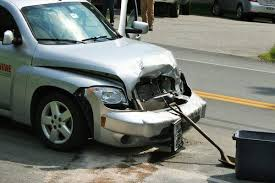

c to continue, q to quitc


In [ ]:
view_images('./car-damage-dataset/data2a/validation/00-front/', front1)

In [ ]:
len(front1)

1

In [ ]:
len(front2)

33

In [ ]:
len(rear1)

19

In [ ]:
len(rear2)

27